In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
from sklearn.datasets import make_blobs, make_classification
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from libact.base.dataset import Dataset
from libact.models import LogisticRegression
from libact.query_strategies import UncertaintySampling, RandomSampling
sns.set()
from scipy.special import softmax
from scipy import stats
import time
import warnings
warnings.simplefilter('ignore')

Variance Reduction C-extension not compiled. Install package with environment variable LIBACT_BUILD_VARIANCE_REDUCTION=1 if intend to run VarianceReduction
HintSVM C-extension not compiled. Install package with environment variableLIBACT_BUILD_HINTSVM=1 if intend to run HintSVM


In [3]:

with open('C:\\Users\\User\\PycharmProjects\\textual-membership-queries-master\\lib\\models\\word2vec_models\\my_w2v.txt', 'r', encoding='utf8') as f:
    for i, l in enumerate(f):
        pass
    print(i + 1)

486572


In [8]:
def generate_data(seed=1):
    X, y = make_classification(TRAIN_SIZE+VAL_SIZE+TEST_SIZE,n_features=N_FEATURES, n_redundant=0, n_informative=N_FEATURES-N_USELESS, 
                               n_clusters_per_class=1,class_sep=0.8,weights=(0.6,0.4), random_state=seed)
    return X,y

def active_learning(X_train, y_train, X_test, y_test):
    random = np.random.RandomState(1)
    start_size = 5
    
    idx = random.choice(len(y_train), start_size, False)
    while len(set(y_train[idx])) == 1:
        idx = random.choice(len(y_train), start_size, False)
    round_labels = np.array([None] * len(y_train))
    round_labels[idx] = y_train[idx]
    train_ds = Dataset(X_train, round_labels)
    
    opt_model = LogisticRegression(C=100)
    model = LogisticRegression(C=100)
    trained_opt = False
    
    strategy = UncertaintySampling(train_ds, model=model)
    test_ds = Dataset(X_test, y_test)
    accs = []

    for i in range(len(y_train) - start_size):
        ask_id = strategy.make_query()
        core_size = start_size + i
        current_model = strategy.model

        # TEST
        test_score = current_model.score(test_ds)
        if i and (test_score > max(accs)) and i < subset_size:
            opt_model.train(train_ds)
        
        if i == subset_size and not trained_opt:
            opt_model.train(train_ds)

        prev_ask_id = ask_id
        lbl = y_train[ask_id]

        train_ds.update(ask_id, lbl)
        accs.append(test_score)
    
    return accs[-1], max(accs), opt_model.model, strategy.model.model

def set_separating_planes(opt_model, final_model):
    p = plt.figure(figsize=(6,6))
    w1, w2 = opt_model.coef_.T
    c_opt = -opt_model.intercept_[0]/w2
    m_opt = -w1/w2
    xmin, xmax = -1,3#X_test[:,0].min(), X_test[:,0].max()
    xd = np.array([xmin, xmax])
    yd = m_opt*xd + c_opt
    plt.plot(xd, yd, 'k', lw=1, ls='solid', c='r', label='optimal plane')

    b = final_model.intercept_[0]
    w1, w2 = final_model.coef_.T
    c = -b/w2
    m = -w1/w2

    xd = np.array([xmin, xmax])
    yd = m*xd + c
    plt.plot(xd, yd, 'k', lw=1, ls='--', label='final plane')
    return p

def generate_samples(original_train_size, seed):
    mask_matrix = np.zeros((N_sampled_subsets,original_train_size), dtype=bool)
    idx = list(range(original_train_size))
    rng = np.random.RandomState(seed)
    for i in range(N_sampled_subsets):
        sample = rng.choice(idx, subset_size, replace=False)
        mask_matrix[i, sample] = 1
    return mask_matrix

def get_train_scores(X_train,y_train, X_test, y_test, seed):
    mask_matrix = generate_samples(TRAIN_SIZE, seed)    
    
    mask_results = np.zeros(N_sampled_subsets)
    for i in range(N_sampled_subsets):
        model = lm.LogisticRegression(C=100)
        model.fit(X_train[mask_matrix[i]], y_train[mask_matrix[i]])
        mask_results[i] = model.score(X_test, y_test)
    
    train_scores = np.zeros(TRAIN_SIZE)
    for train_sample_index in range(TRAIN_SIZE):
        idx = mask_matrix[:,train_sample_index]
        r = mask_results[idx].mean() - mask_results[np.logical_not(idx)].mean()
        train_scores[train_sample_index] = r
    train_scores = train_scores*TRAIN_SIZE
    
    return train_scores, mask_results.mean()

In [9]:
def experiment(seed, viz=False):
    X, y = generate_data(seed)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=seed)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=TEST_SIZE, random_state=seed+1)
    
    final_val_accuracy, peaking_AL_accuracy, opt_model, complete_model = active_learning(X_train, y_train, X_val, y_val)
    final_test_accuracy = complete_model.score(X_test, y_test)
    
    model = lm.LogisticRegression(C=100)
    model.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]))
    complete_data_accuracy = model.score(X_val, y_val)
    
    #stats.ttest_rel(strategy.model.model.predict(X_test) == y_test,opt_model.model.predict(X_test) == y_test)
    train_scores, mean_random_accuracy = get_train_scores(X_train,y_train, X_val, y_val, seed)
    

    #for k in [700,800,900]:
    k = int(TRAIN_SIZE*0.9)
    idx = np.argpartition(train_scores, -k)[-k:]
    indices = idx[np.argsort((-train_scores)[idx])]
    #query = np.argmax(train_scores, k)
    model.fit(X_train[indices],  y_train[indices])
    naive_top_k = model.score(X_val, y_val)
    
    
    #for k in [50,100,150]:
    k=int(TRAIN_SIZE*0.1)
    indices = np.random.RandomState(100).choice(TRAIN_SIZE, subset_size-2*k, False)
    for i in [0,1]:
        train_0_scores = np.array(train_scores)
        q = np.logical_not(y_train) if i else y_train
        train_0_scores[q] = -100000000

        idx = np.argpartition(train_scores, -k)[-k:]
        extra_indices = idx[np.argsort((-train_scores)[idx])]
        
        indices = np.hstack([indices, extra_indices])
    #query = np.argmax(train_scores, k)
    model.fit(X_train[indices], y_train[indices])
    mixed_top_k = model.score(X_val, y_val)
    
    sc = []
    p = softmax(train_scores)
    for i in range(TRAIN_SIZE):
        indices = np.random.choice(TRAIN_SIZE, subset_size, False, p=p)
        model.fit(X_train[indices],  y_train[indices])
        s = model.score(X_val, y_val)
        sc.append(s)
    
    if viz:
        set_separating_planes(opt_model, complete_model)
        p = sns.scatterplot(x=X_val[:, 0], y=X_val[:,1], hue=y_val)
        
        #print('scores statistics: ', train_scores.min(), train_scores.max(), np.median(train_scores), train_scores.mean())
        df = pd.DataFrame(train_scores, columns=['score'])
        df['label'] = y_train
        plt.figure(figsize=(10,6))
        sns.kdeplot(data=df, x='score', hue='label')
        
        set_separating_planes(opt_model, complete_model)
        p = sns.scatterplot(x=X_train[:, 0], y=X_train[:,1], hue=train_scores, style=y_train)
        
        set_separating_planes(opt_model, complete_model)
        q = abs(train_scores) > 0.7
        p = sns.scatterplot(x=X_train[q, 0], y=X_train[q,1], hue=train_scores[q], style=y_train[q])
        
        plt.figure(figsize=(10,6))
        p = sns.kdeplot(sc-final_val_accuracy)
        plt.xlabel('Distribution of quality difference with baseline for 10000 sampled subsets')
        
        plt.figure(figsize=(10,6))
        unc_1 = complete_model.predict_proba(X_train).min(axis=1)
        sns.regplot(y='ATE', x='Uncertainty', data=pd.DataFrame(np.stack([train_scores, unc_1]).T, columns=['ATE', 'Uncertainty']))
        
    return final_test_accuracy, complete_data_accuracy, opt_model.score(X_test, y_test), mean_random_accuracy,naive_top_k,mixed_top_k,np.mean(sc), len([x for x in sc if x>final_val_accuracy]), stats.ttest_1samp(sc, complete_data_accuracy, alternative='less').pvalue, stats.ttest_1samp(sc, complete_data_accuracy, alternative='greater').pvalue


32.71300292015076

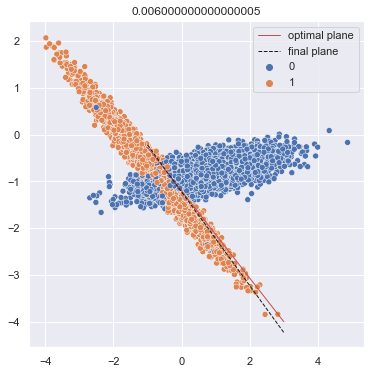

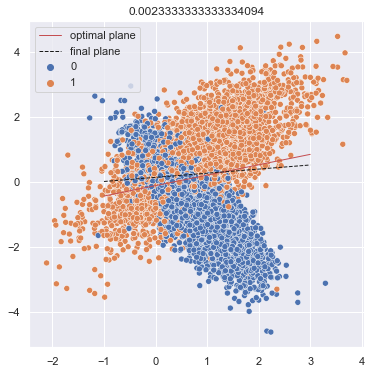

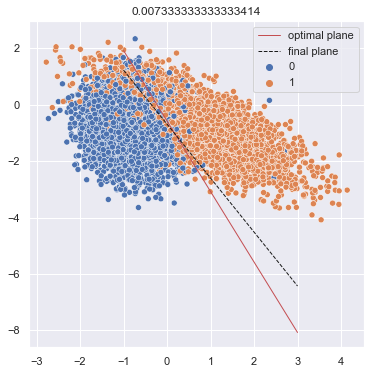

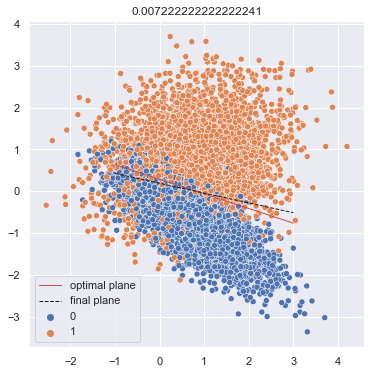

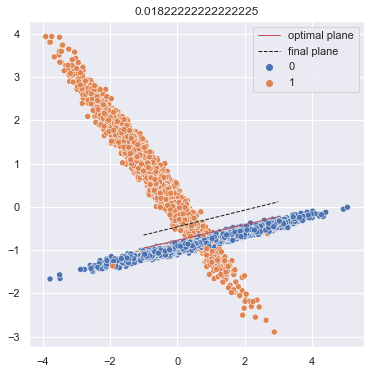

In [14]:
TRAIN_SIZE = 1000
VAL_SIZE = 9000
TEST_SIZE = 10000
N_FEATURES = 2
N_USELESS = 0
N_sampled_subsets = 10000
subset_size = 250
start = time.time()
results = []
n_experiments = 5
for seed in range(n_experiments):
    X, y = generate_data(10+seed)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=seed)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=TEST_SIZE, random_state=seed+1)
    
    final_val_accuracy, peaking_AL_accuracy, opt_model, complete_model = active_learning(X_train, y_train, X_val, y_val)
    final_test_accuracy = complete_model.score(X_test, y_test)
    
    model = lm.LogisticRegression()
    model.fit(np.vstack([X_train, X_val]), np.hstack([y_train, y_val]))
    complete_data_accuracy = model.score(X_val, y_val)
    set_separating_planes(opt_model, complete_model)
    p = sns.scatterplot(x=X_val[:, 0], y=X_val[:,1], hue=y_val)
    p.set_title(peaking_AL_accuracy-final_val_accuracy)
time.time() - start

In [ ]:
df = pd.DataFrame(results, columns='full_train train_val AL_subset random_subset top_900 mixed_top_50 mean_sample_accuracy number_good_subsets pvalue_less pvalue_greater'.split(' '))
df['dataset'] = list(range(df.shape[0]))
df = df.sort_values('full_train')
df.to_csv('2_features.csv')
df.head()

In [15]:
start = time.time()

N_FEATURES = 15
results15 = []
n_experiments = 500
for seed in range(n_experiments):
    current = experiment(seed)
    results15.append(current)
    if seed % 100 == 9:
        print(seed+1, time.time()-start)
time.time() - start

10 723.5663239955902
110 8539.292741060257
210 16330.714313030243
310 23975.318689107895
410 31727.196068048477


38667.83874130249

In [16]:
df = pd.DataFrame(results15, columns='full_train train_val AL_subset random_subset top_900 mixed_top_50 mean_sample_accuracy number_good_subsets pvalue_less pvalue_greater'.split(' '))
df['dataset'] = list(range(df.shape[0]))
df = df.sort_values('full_train')
df.to_csv('15_features.csv')
df.head()

,full_train,train_val,AL_subset,random_subset,top_900,mixed_top_50,mean_sample_accuracy,number_good_subsets,pvalue_less,pvalue_greater,dataset
208,0.7532,0.764222,0.7445,0.747140,0.783222,0.712778,0.770808,1000,1.000000e+00,2.456582e-107,208
230,0.7566,0.760222,0.7337,0.736696,0.765667,0.731556,0.752082,1000,1.048103e-164,1.000000e+00,230
119,0.7756,0.783889,0.7860,0.766722,0.834556,0.790333,0.828231,1000,1.000000e+00,0.000000e+00,119
168,0.7765,0.780667,0.7774,0.763102,0.782444,0.676000,0.771865,1000,7.639944e-285,1.000000e+00,168
347,0.7847,0.796111,0.8278,0.781544,0.831333,0.696000,0.820514,1000,1.000000e+00,0.000000e+00,347


In [18]:
start = time.time()

N_FEATURES = 15
N_USELESS = 5
results10 = []
n_experiments = 500
for seed in range(n_experiments):
    current = experiment(seed)
    results10.append(current)
    if seed % 100 == 9:
        print(seed+1, time.time()-start)
time.time() - start

10 707.772848367691
110 7790.014702796936
210 14927.152049303055
310 22122.35059952736
410 29178.063979148865


35519.29822969437

In [19]:
df = pd.DataFrame(results10, columns='full_train train_val AL_subset random_subset top_900 mixed_top_50 mean_sample_accuracy number_good_subsets pvalue_less pvalue_greater'.split(' '))
df['dataset'] = list(range(df.shape[0]))
df = df.sort_values('full_train')
df.to_csv('10_features.csv')
df.head()

,full_train,train_val,AL_subset,random_subset,top_900,mixed_top_50,mean_sample_accuracy,number_good_subsets,pvalue_less,pvalue_greater,dataset
425,0.7034,0.719778,0.7002,0.686150,0.800000,0.547000,0.785662,1000,1.000000e+00,0.000000e+00,425
439,0.7122,0.719000,0.7690,0.697144,0.733889,0.731556,0.722109,1000,1.000000e+00,5.995729e-25,439
148,0.7296,0.737000,0.7034,0.724382,0.741222,0.640222,0.731829,1000,2.763021e-163,1.000000e+00,148
247,0.7377,0.742000,0.7875,0.719643,0.780778,0.641000,0.772959,1000,1.000000e+00,0.000000e+00,247
92,0.7449,0.745444,0.7694,0.727814,0.801333,0.706111,0.792488,1000,1.000000e+00,0.000000e+00,92


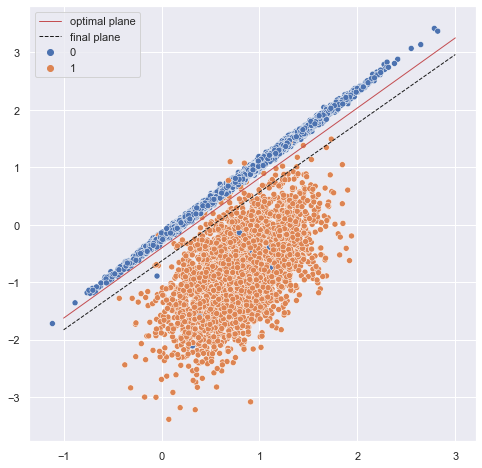

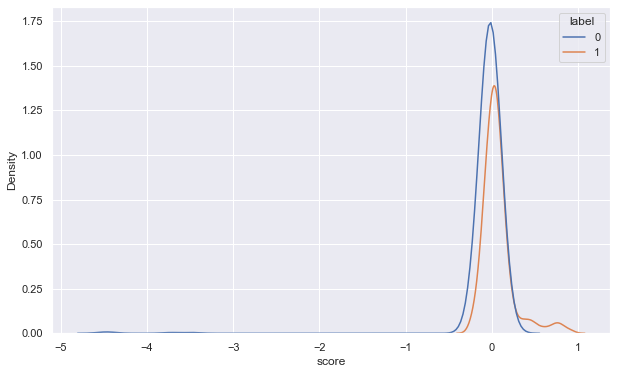

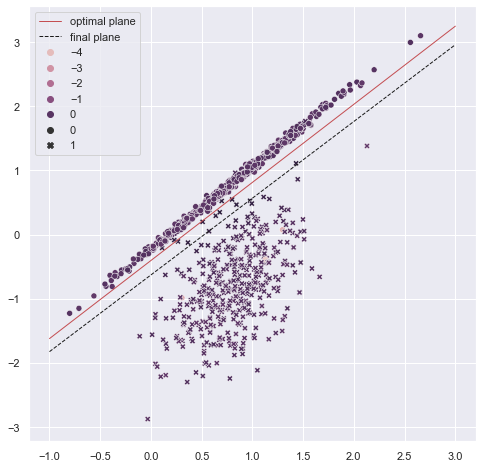

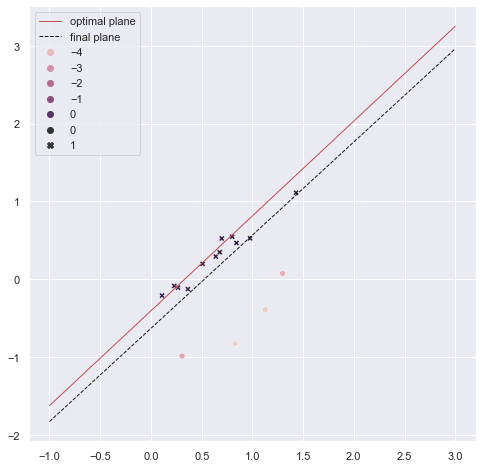

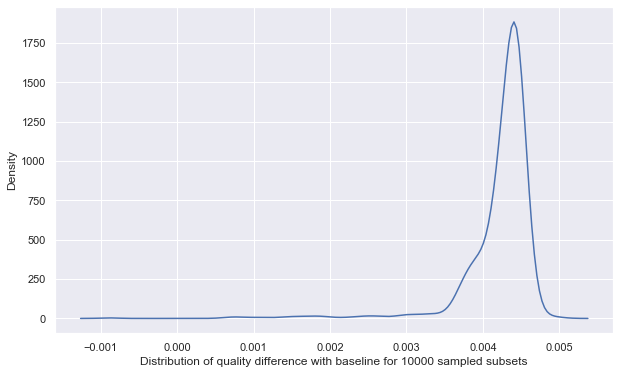

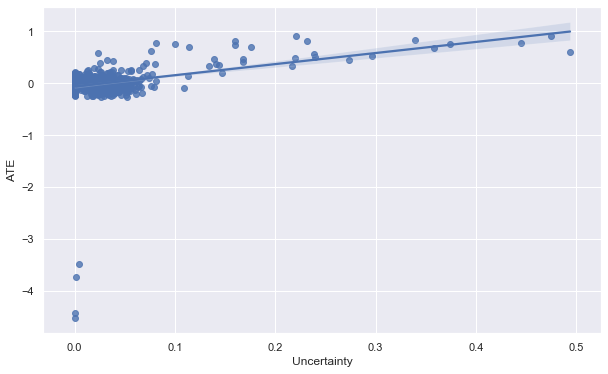

In [79]:
TRAIN_SIZE = 1000
VAL_SIZE = 9000
TEST_SIZE = 10000
N_FEATURES = 2
N_USELESS = 0
N_sampled_subsets = 10000
subset_size = 250

current = experiment(1, True)

In [24]:
df = pd.read_csv('2_features.csv')
competitors = ['top_900', 'mixed_top_50', 'mean_sample_accuracy', 'AL_subset', 'train_val']
for c in competitors:
    print(c, (df[c] - df.full_train).mean()*100, sum(df[c]>df.full_train),sum(df[c]>df.full_train-0.01))

top_900 0.3858999999999996 542 933
mixed_top_50 -7.810933333333332 113 213
mean_sample_accuracy 0.35987428888888895 604 977
AL_subset 0.2639799999999992 714 981
train_val 0.05032222222222187 542 982


In [26]:
df = pd.read_csv('10_features.csv')
competitors = ['top_900', 'mixed_top_50', 'mean_sample_accuracy', 'AL_subset', 'train_val']
for c in competitors:
    print(c, (df[c] - df.full_train).mean()*100, sum(df[c]>df.full_train)/5,sum(df[c]>df.full_train-0.01)/5)

top_900 0.8457422222222214 83.8 100.0
mixed_top_50 -5.9587022222222235 3.8 9.4
mean_sample_accuracy -0.07569013333333308 33.2 89.4
AL_subset 0.04516000000000027 46.8 92.4
train_val 0.37463111111111147 77.0 99.2


In [27]:
df = pd.read_csv('15_features.csv')
competitors = ['top_900', 'mixed_top_50', 'mean_sample_accuracy', 'AL_subset', 'train_val']
for c in competitors:
    print(c, (df[c] - df.full_train).mean()*100, sum(df[c]>df.full_train)/5,sum(df[c]>df.full_train-0.01)/5)

top_900 0.7391688888888893 82.2 100.0
mixed_top_50 -5.885697777777775 2.8 8.0
mean_sample_accuracy -0.16779388888888858 31.6 91.8
AL_subset -0.06043999999999996 41.8 92.8
train_val 0.3919466666666666 79.4 100.0


Text(0.5, 1.0, 'Cumulative distribution of accuracy change (datasets with 10+5 features)')

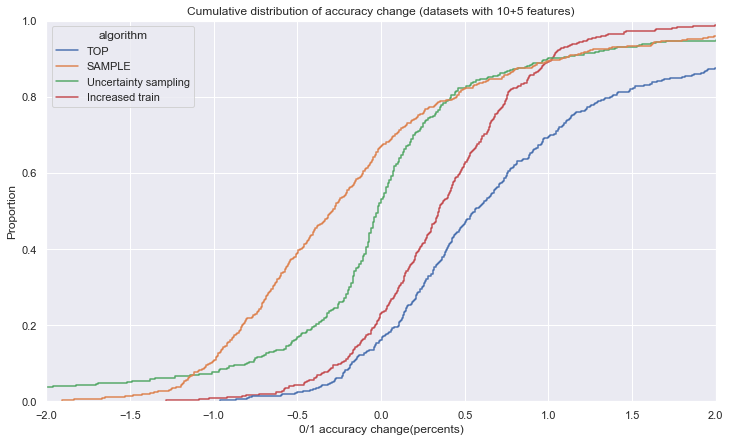

In [85]:
df = pd.read_csv('10_features.csv')
competitors = ['top_900', 'mean_sample_accuracy', 'AL_subset', 'train_val']
c_new = ['TOP', 'SAMPLE', 'Uncertainty sampling', 'Increased train']
for i, c in enumerate(competitors):
    df[c_new[i]] = (df[c] - df.full_train)*100
melted = pd.melt(df[c_new],value_vars=c_new, var_name='algorithm', value_name='0/1 accuracy change(percents)')
plt.figure(figsize=(12,7))
plt.xlim(-2,2)
sns.ecdfplot(data=melted, hue='algorithm', x='0/1 accuracy change(percents)')
plt.title('Cumulative distribution of accuracy change (datasets with 10+5 features)')

In [88]:
df = pd.read_csv('10_features.csv')
df[(df.full_train < df.mean_sample_accuracy) & (df.AL_subset < df.full_train)].shape

(49, 12)

In [89]:
df = pd.read_csv('10_features.csv')
df[(df.full_train > df.mean_sample_accuracy) & (df.AL_subset > df.full_train)].shape

(118, 12)

In [90]:
df = pd.read_csv('10_features.csv')
df[(df.AL_subset > df.full_train)].shape

(234, 12)

In [91]:
df = pd.read_csv('10_features.csv')
df[(df.full_train < df.mean_sample_accuracy)].shape

(166, 12)

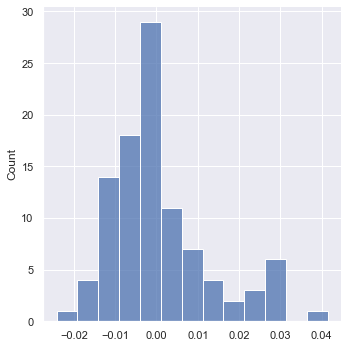

In [5]:
sns.displot(df.top_900 - df.full_train)

In [6]:
df.shape

(100, 12)

In [6]:
df[(df.AL_subset > df.mean_sample_accuracy) & (df.AL_subset > df.full_train)].shape

(57, 11)

In [7]:
df[(df.AL_subset < df.mean_sample_accuracy) & (df.mean_sample_accuracy > df.full_train)].shape

(23, 11)

In [8]:
df[(df.train_val < df.mean_sample_accuracy) | (df.AL_subset > df.train_val)].shape

(74, 11)

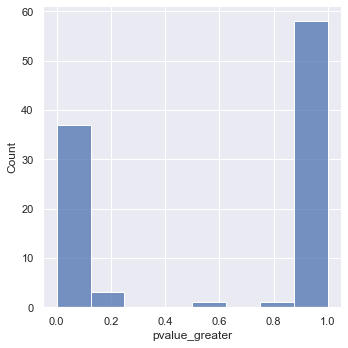

In [9]:
sns.displot(df.pvalue_greater)

In [44]:
df.head()

,Unnamed: 0,full_train,train_val,AL_subset,random_subset,top_900,mixed_top_50,mean_sample_accuracy,number_good_subsets,pvalue_less,pvalue_greater,dataset
0,28,0.7349,0.738778,0.7360,0.738173,0.763111,0.605667,0.750762,1000,1.0,1.819887e-258,28
1,640,0.7508,0.752111,0.7555,0.746944,0.773889,0.653556,0.762801,1000,1.0,4.053597e-219,640
2,863,0.7546,0.748667,0.7942,0.749243,0.802444,0.737778,0.798520,1000,1.0,0.000000e+00,863
3,769,0.7577,0.755222,0.8179,0.760677,0.807444,0.749333,0.805618,1000,1.0,0.000000e+00,769
4,299,0.7579,0.778889,0.7992,0.762805,0.844778,0.801333,0.847058,1000,1.0,0.000000e+00,299


In [50]:
df[competitors]

,top_900,mean_sample_accuracy,AL_subset,train_val,dataset
0,0.763111,0.750762,0.7360,0.738778,28
1,0.773889,0.762801,0.7555,0.752111,640
2,0.802444,0.798520,0.7942,0.748667,863
3,0.807444,0.805618,0.8179,0.755222,769
4,0.844778,0.847058,0.7992,0.778889,299
...,...,...,...,...,...
995,0.995333,0.995185,0.9962,0.995333,345
996,0.995444,0.995377,0.9962,0.995444,484
997,0.995222,0.995130,0.9958,0.995222,730
998,0.995667,0.995603,0.9963,0.995667,356
